In [ ]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

warnings.filterwarnings("ignore")

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

pal = [
    "#be0707",
    "#dc3248",
    "#ef5a80",
    "#f982b2",
    "#fca9dd",
    "#ffcfff",
    "#eebdfb",
    "#daacf9",
    "#c19cf8",
    "#a48ef7",
    "#7e82f7",
]

sns.set_theme(style="white", palette=pal, rc={"figure.figsize": (12, 8)})
plt.rcParams["figure.figsize"] = (12, 8)

In [1]:
from google.cloud import bigquery

project = "analytics-147612"
location = "EU"
client = bigquery.Client(project=project, location=location)


def table_reference(dataset, table):
    return f"{project}.{dataset}.{table}"

In [3]:
time_to_activate_query = """
SELECT
    u.user_id
    , UPPER(u.country) AS country_name
    , TIMESTAMP_DIFF(MIN(d.created_dt), MIN(u.registered_dt), analytics.second) AS time_diff
FROM
    analytics-147612.wh_raw.users u
JOIN
  analytics-147612.wh_raw.deposits_enhanced d
ON
  u.user_id = d.user_id
WHERE
  u.registered_dt > '2024-01-01T00:00:00'
  AND d.deposit_number = 0
GROUP BY
  u.user_id,
  country_name
"""
time_to_activate = client.query(time_to_activate_query).to_dataframe()

In [41]:
time_to_activate_enhanced_query = """
WITH d AS (
    SELECT
        user_id,
        amount_usd,
        source,
        MIN(created_dt) AS first_deposit_dt
    FROM analytics-147612.wh_raw.deposits_enhanced
    WHERE deposit_number = 0
    GROUP BY user_id, amount_usd, source
),

all_geo AS (
    SELECT
        u.user_id,
        d.amount_usd AS first_deposit_amount,
        d.source AS registration_source,
        UPPER(c.code) AS country_code,
        CAST(
            TIMESTAMP_DIFF(
                MIN(d.first_deposit_dt), MIN(u.registered_dt), SECOND
            ) AS INT64
        ) AS activation_window_seconds,
        MIN(u.registered_dt) AS registered_dt
    FROM
        analytics-147612.wh_raw.users AS u
    INNER JOIN
        d
        ON
            u.user_id = d.user_id
    INNER JOIN
        analytics-147612.wh_raw.countries AS c
        ON u.country = c.country
    WHERE
        u.registered_dt > '2024-01-01T00:00:00'
    GROUP BY
        u.user_id,
        country_code,
        first_deposit_amount,
        registration_source
)

SELECT * FROM all_geo
WHERE country_code IN (
    'IND', 'IDN', 'NGA', 'ZAF', 'MYS', 'BRA'
)
  """
time_enhanced = client.query(time_to_activate_enhanced_query).to_dataframe()
time_enhanced.to_csv("time_to_activate_enhanced.csv", index=False)

In [45]:
time_enhanced

,user_id,first_deposit_amount,registration_source,country_code,activation_window_seconds,registered_dt
0,37553501,25.68,app,IDN,271,2024-01-14 16:09:21+00:00
1,37718112,50.00,app,IND,15510,2024-01-21 03:37:19+00:00
2,37542871,100.00,site,ZAF,387,2024-01-14 07:39:53+00:00
3,37544140,100.00,site,ZAF,199,2024-01-14 08:41:53+00:00
4,37748757,100.96,site,IDN,258,2024-01-22 12:21:55+00:00
...,...,...,...,...,...,...
19691,37977588,31.90,site,IDN,103146,2024-02-02 04:22:29+00:00
19692,38072695,25.44,app,IDN,1966,2024-02-05 12:04:02+00:00
19693,37972671,25.35,app,IDN,2754,2024-02-01 21:50:21+00:00
19694,37793295,25.42,app,IDN,46095,2024-01-24 14:09:26+00:00


In [42]:
accounts_query = f"""
with activations_enhanced as ({time_to_activate_enhanced_query})
SELECT
    ta.user_id,
    ta.platform_id,
    ta.server_id,
    ta.leverage,
    ta.created_dt,
    tr.open_time_dt
FROM
    `analytics-147612.wh_raw.trading_accounts` AS ta
INNER JOIN
    (SELECT
         user_id,
         MIN(open_time_dt) AS first_open_time
     FROM
         `analytics-147612.wh_raw.trading_real_raw`
     GROUP BY
         user_id) AS tr_first_open
ON
    ta.user_id = tr_first_open.user_id
INNER JOIN
    `analytics-147612.wh_raw.trading_real_raw` AS tr
ON
    tr.user_id = tr_first_open.user_id
AND
    tr.open_time_dt = tr_first_open.first_open_time
WHERE ta.user_id in (SELECT user_id FROM activations_enhanced)
"""
accounts = client.query(
    accounts_query.format(time_to_activate_enhanced_query)
).to_dataframe()
accounts.to_csv("accounts.csv", index=False)

In [49]:
accounts_dedup = accounts.drop_duplicates(subset="user_id", keep="first")

merged_df = pd.merge(time_enhanced, accounts_dedup, on="user_id", how="inner")

merged_df.head()

,user_id,first_deposit_amount,registration_source,country_code,activation_window_seconds,registered_dt,platform_id,server_id,leverage,created_dt,open_time_dt
0,37553501,25.68,app,IDN,271,2024-01-14 16:09:21+00:00,3,1,500,2024-01-14 16:19:38+00:00,2024-01-15 08:02:37.077100+00:00
1,37718112,50.00,app,IND,15510,2024-01-21 03:37:19+00:00,4,2,200,2024-01-21 03:41:09+00:00,2024-01-31 20:39:06.427600+00:00
2,37569341,128.45,app,IDN,607,2024-01-15 10:06:22+00:00,3,2,500,2024-01-15 10:07:54+00:00,2024-01-15 10:18:18+00:00
3,37522182,18.07,app,IND,752949,2024-01-13 10:15:04+00:00,4,1,500,2024-01-13 10:16:11+00:00,2024-01-22 03:25:34.955700+00:00
4,37526594,18.07,app,IND,321735,2024-01-13 13:49:22+00:00,4,2,500,2024-01-13 15:50:33+00:00,2024-01-19 02:34:44.783400+00:00


In [78]:
import uuid

print(str(uuid.uuid4()).replace("-", "")[:15])

8651329e12c645e


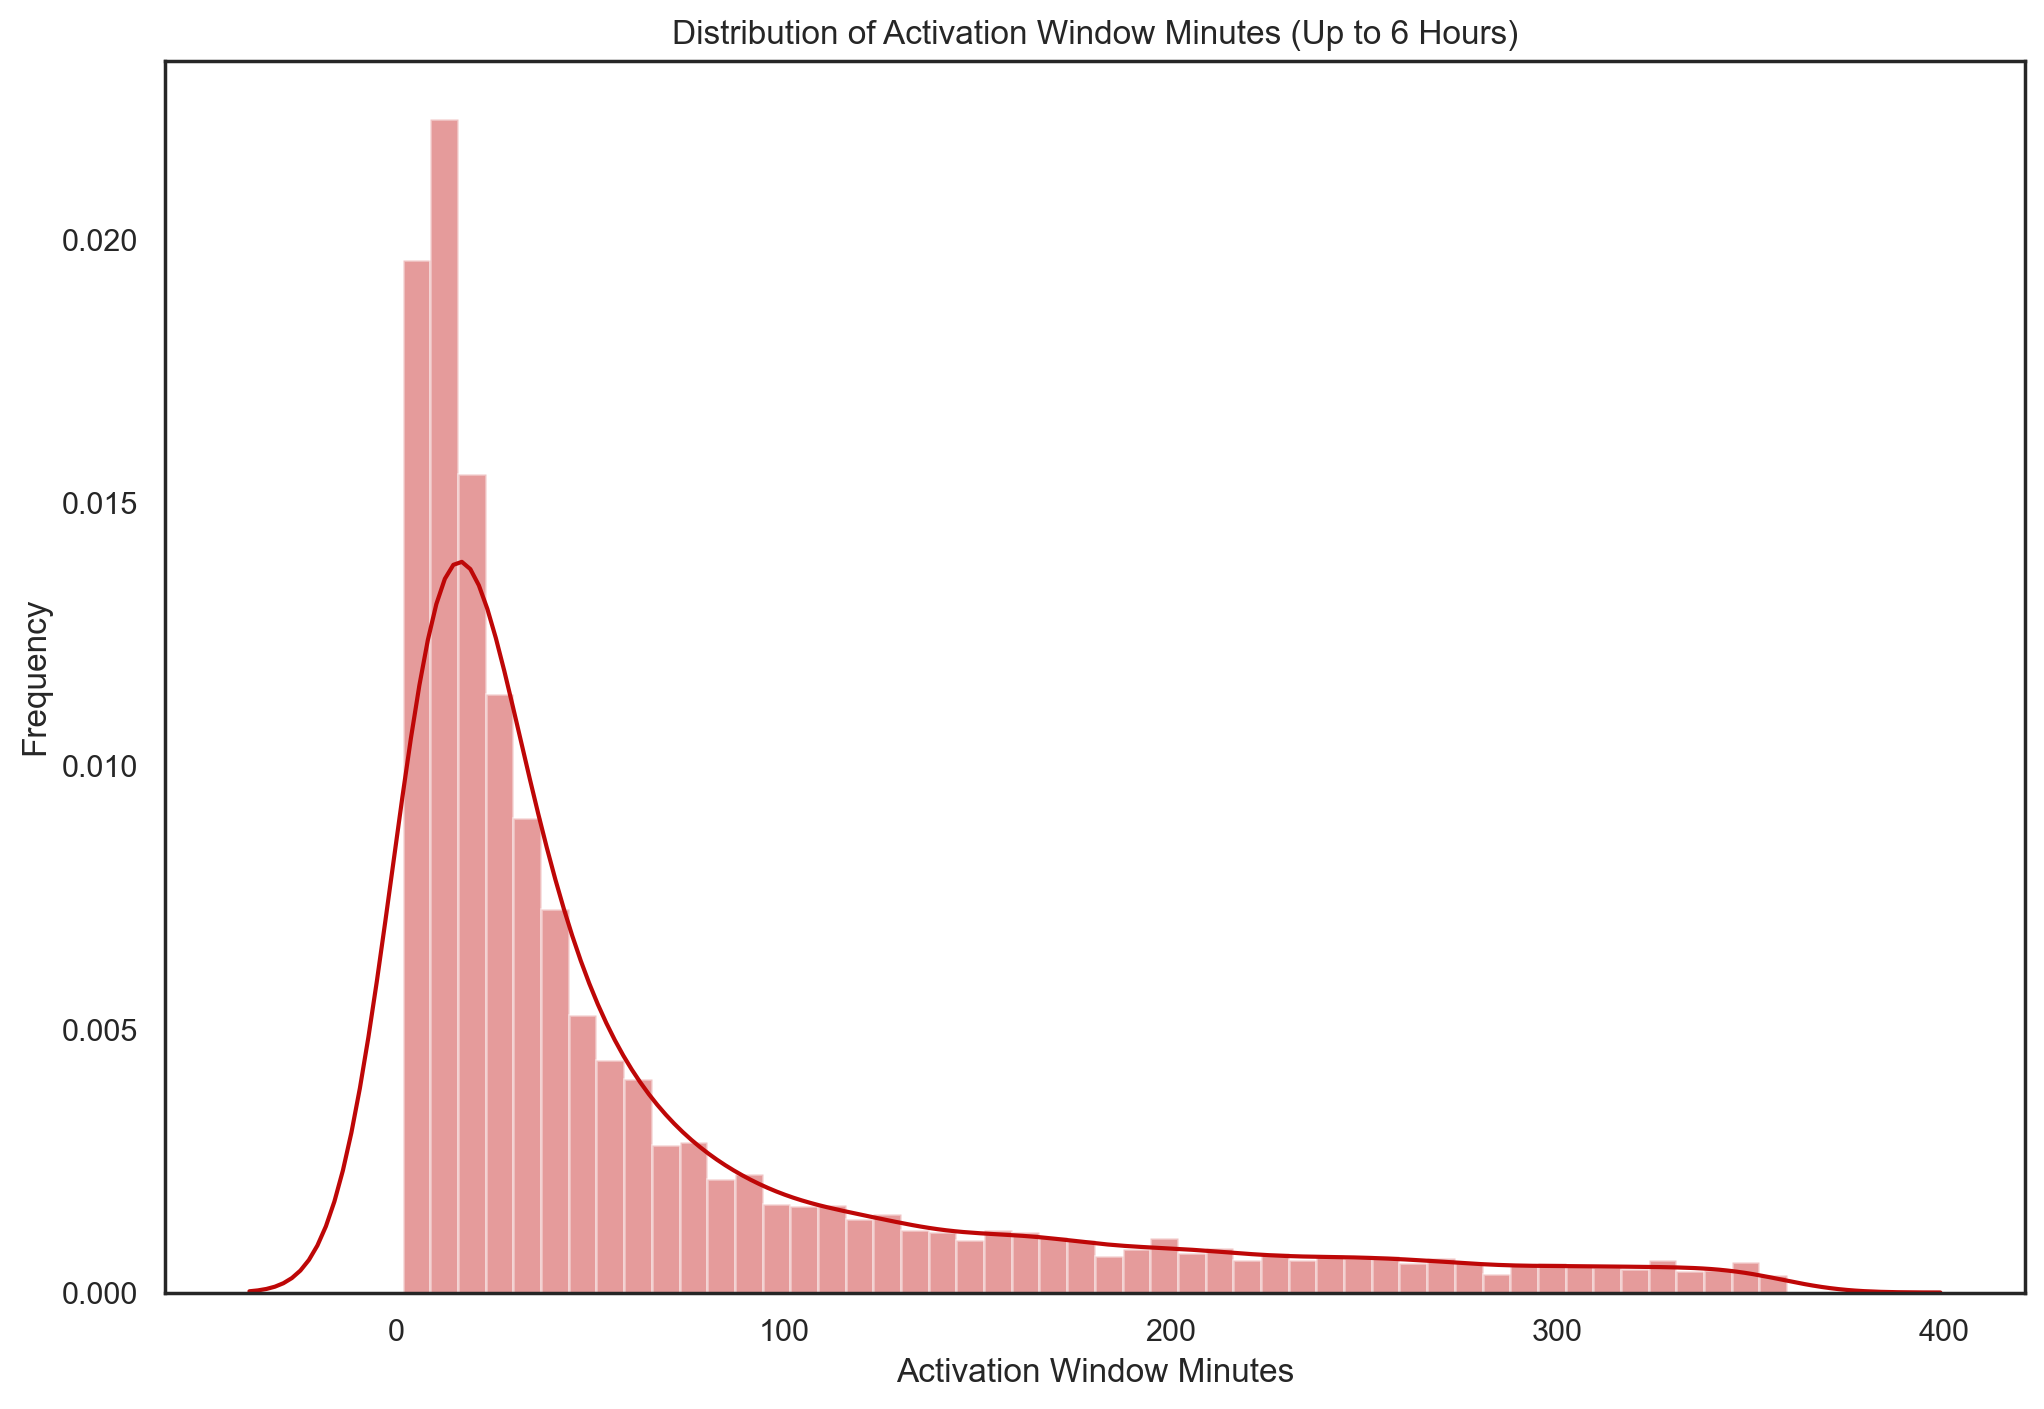

In [57]:
# Filter the dataframe to include only users with an activation window of 6 hours or less (21600 seconds)
filtered_df = merged_df[merged_df["activation_window_seconds"] <= 21600]

filtered_df["activation_window_minutes"] = (
    filtered_df["activation_window_seconds"].to_numpy() / 60
)

sns.distplot(filtered_df["activation_window_minutes"].to_numpy(), bins=50, kde=True)
plt.title("Distribution of Activation Window Minutes (Up to 6 Hours)")
plt.xlabel("Activation Window Minutes")
plt.ylabel("Frequency")
plt.show()

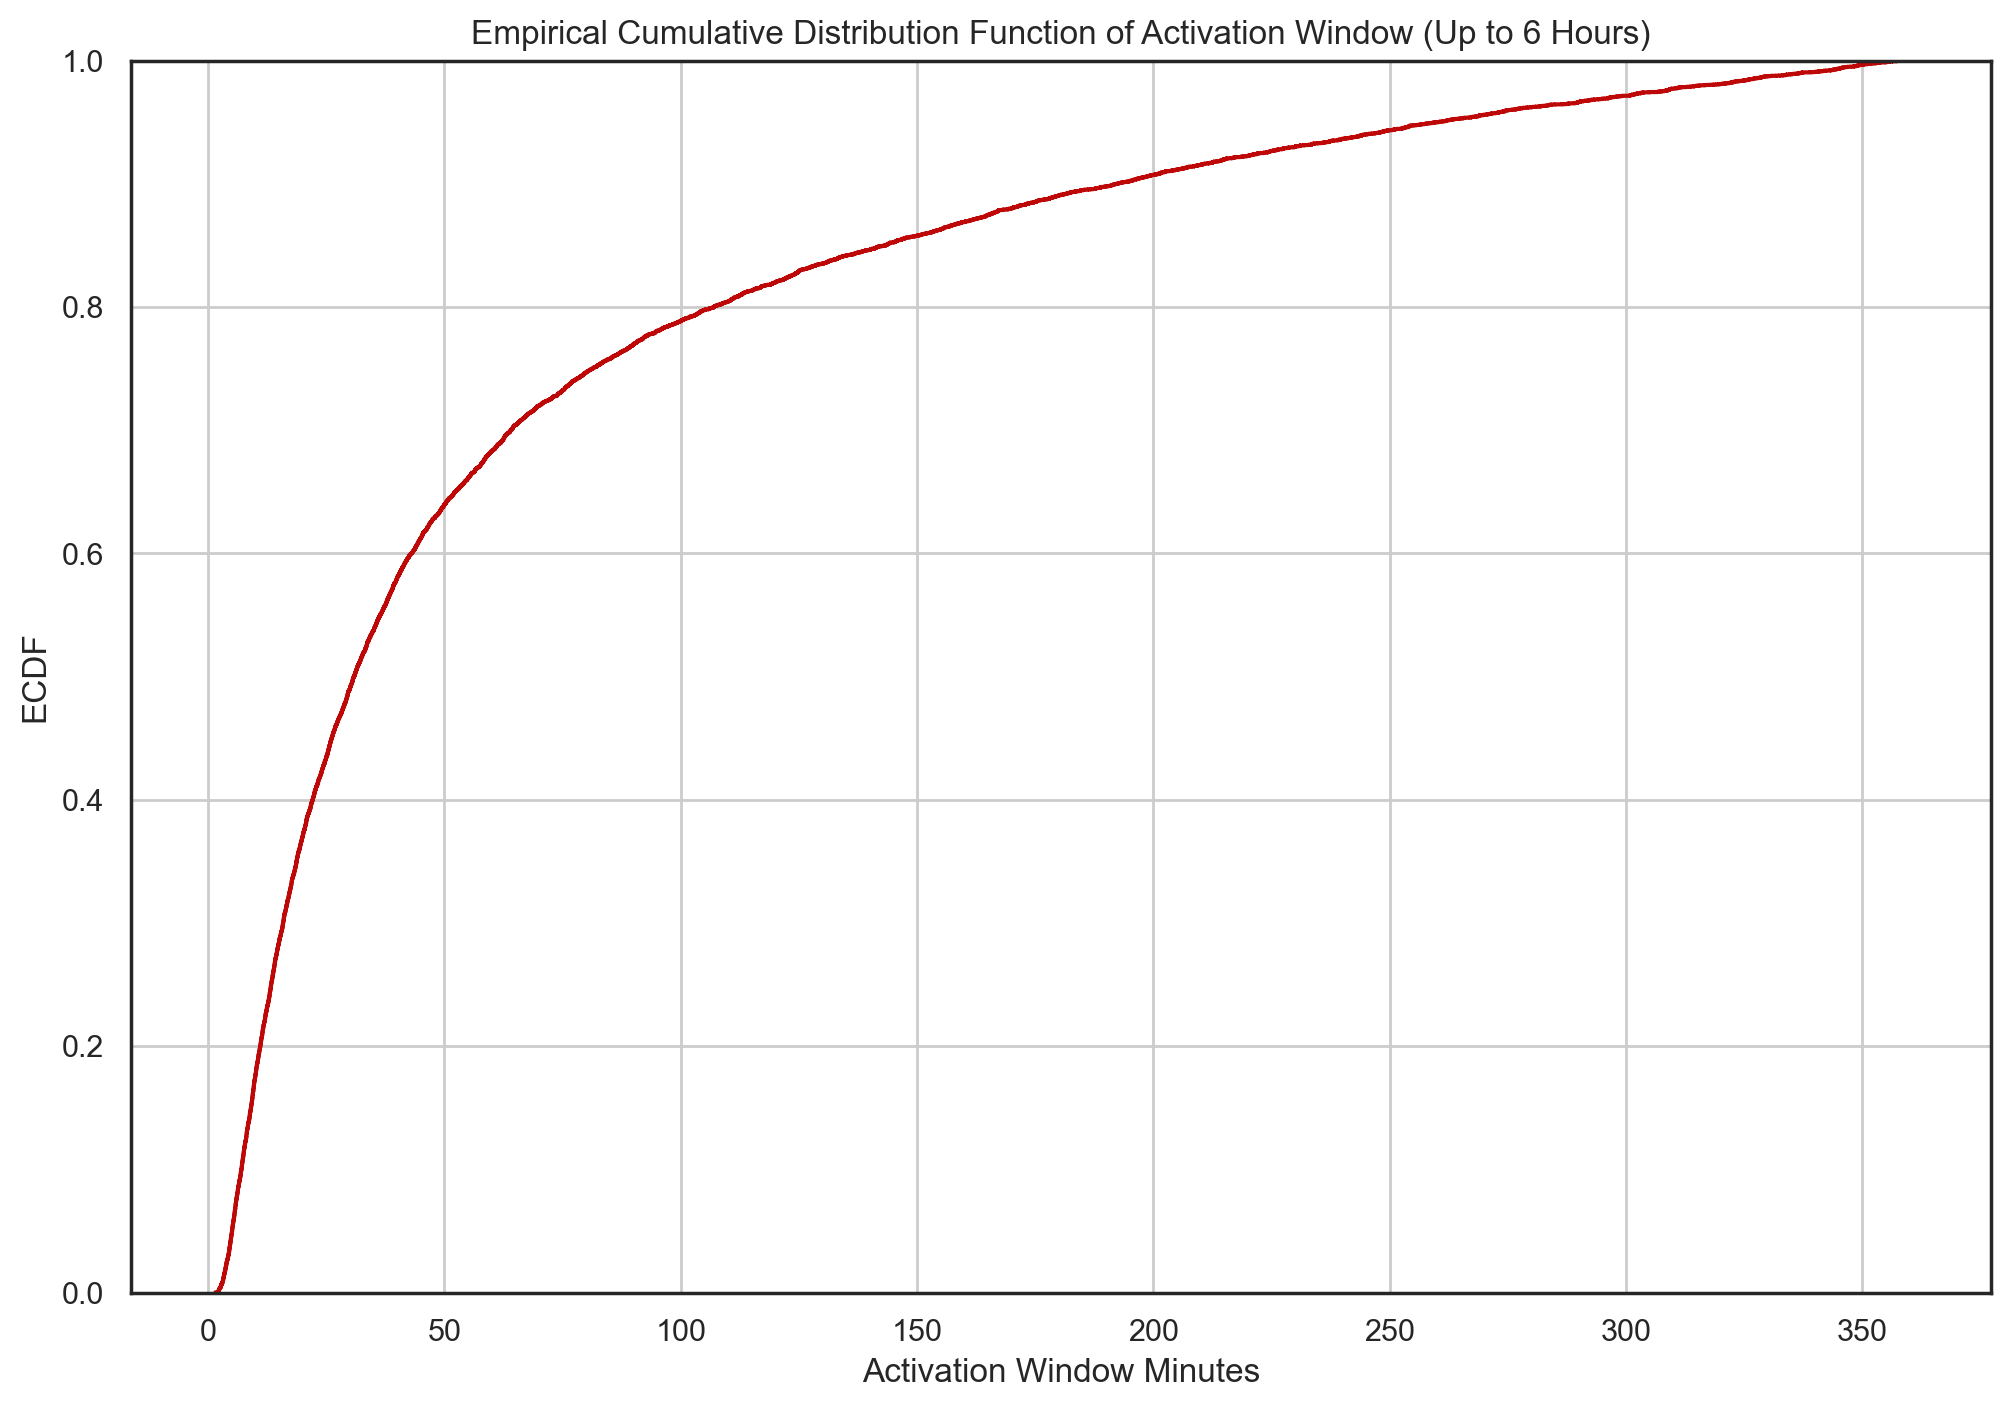

In [58]:
sns.ecdfplot(filtered_df["activation_window_minutes"])
plt.title(
    "Empirical Cumulative Distribution Function of Activation Window (Up to 6 Hours)"
)
plt.xlabel("Activation Window Minutes")
plt.ylabel("ECDF")
plt.grid(True)
plt.show()

In [62]:
percentiles = np.arange(0, 100, 5)
filtered_activation_window_percentiles = (
    filtered_df["activation_window_minutes"]
    .quantile([p / 100 for p in percentiles])
    .to_dict()
)
activation_window_percentiles = (
    merged_df["activation_window_seconds"]
    .quantile([p / 100 for p in percentiles])
    .to_dict()
)

In [84]:
fig = px.ecdf(
    filtered_df,
    x="activation_window_minutes",
    title="Interactive ECDF of Activation Window (Up to 6 Hours)",
    width=1200,
    height=800,
)

In [65]:
import plotly.express as px

fig = px.ecdf(
    filtered_df,
    x="activation_window_minutes",
    title="Interactive ECDF of Activation Window (Up to 6 Hours)",
)

fig.add_vline(
    x=filtered_activation_window_percentiles[0.5],
    line_dash="dash",
    line_color="red",
    annotation_text="Median (Filtered <= 6 Hours)",
    annotation_position="bottom right",
)

fig.update_xaxes(title="Activation Window Minutes")
fig.update_yaxes(title="ECDF")
fig.show()